In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Import Libraries

In [2]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import backend as K
from sklearn.preprocessing import LabelEncoder
color = sns.color_palette()
%matplotlib inline


In [3]:
df_dir = '../input/chest-xray-pneumonia/chest_xray/'

In [4]:
#Creating Function for creating Dataframes
def create_data_frame(z = None):
    df = pd.DataFrame(columns=['Class','Location'])
    choices = [z]
    for choice in choices:
        for folder in os.listdir(df_dir+choice+'/'):
            for Class in os.listdir(df_dir+choice+'/'+folder+'/'):
                df = df.append({'Class': folder,'Location':df_dir+choice+'/'+folder+'/'+Class},ignore_index=True)
                df = df.sample(frac = 1.).reset_index(drop=True)
    return df

In [5]:
#create train, test validation data frames 
df_train = create_data_frame('train')
df_test = create_data_frame('test')
df_val = create_data_frame('val')

le = LabelEncoder()
df_train['Class'] = le.fit_transform(df_train['Class'])
df_test['Class'] = le.fit_transform(df_test['Class'])
df_val['Class'] = le.fit_transform(df_val['Class'])

In [6]:
#categories as 
#le.inverse_transform([0, 1])

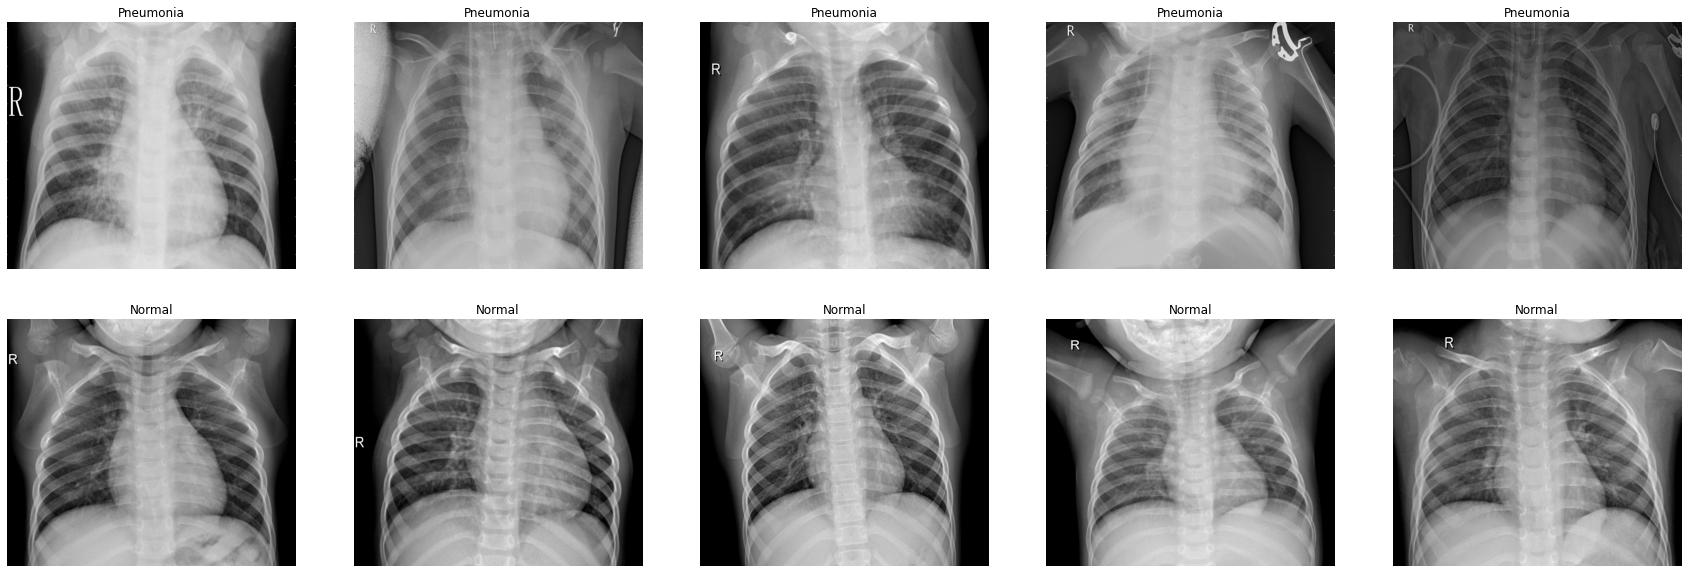

In [7]:
# 
pneumonia_samples = (df_train[df_train['Class']== 1]['Location'].iloc[:5]).tolist()
normal_samples = (df_train[df_train['Class']==0]['Location'].iloc[:5]).tolist()
samples = pneumonia_samples + normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

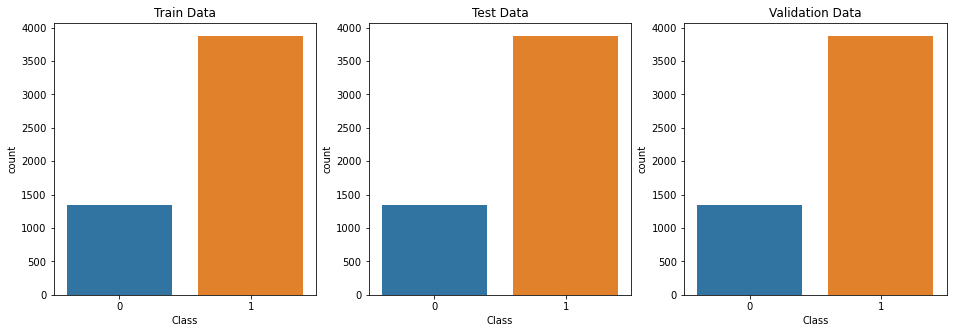

In [8]:
#barchart depicting distributtion of data 
fig = plt.figure(figsize=(16,5))

plt.subplot(1, 3, 1)
sns.countplot(df_train['Class'])
plt.title('Train Data')

plt.subplot(1, 3, 2)
sns.countplot(df_train['Class'])
plt.title('Test Data')

plt.subplot(1, 3, 3)
sns.countplot(df_train['Class'])
plt.title('Validation Data')

plt.show()

In [9]:
df_train.head()

,Class,Location
0,0,../input/chest-xray-pneumonia/chest_xray/train...
1,1,../input/chest-xray-pneumonia/chest_xray/train...
2,1,../input/chest-xray-pneumonia/chest_xray/train...
3,1,../input/chest-xray-pneumonia/chest_xray/train...
4,0,../input/chest-xray-pneumonia/chest_xray/train...


In [10]:
#Process and composing  dataset 
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (64,64,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for label, img_path in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [11]:
#Getting processed data by passing through the required function 
X_train, y_train = compose_dataset(df_train)
X_test, y_test = compose_dataset(df_test)
X_val, y_val = compose_dataset(df_val)

print('The shape of Training after data proessing is: ', X_train.shape, y_train.shape)
print('The shape of Testing after data proessing is: ', X_test.shape, y_test.shape)
print('The shape of Validation after data proessing is: ', X_val.shape, y_val.shape)

The shape of Training after data proessing is:  (5216, 64, 64, 1) (5216,)
The shape of Testing after data proessing is:  (624, 64, 64, 1) (624,)
The shape of Validation after data proessing is:  (16, 64, 64, 1) (16,)


In [12]:
#Image Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
#val_datagen = ImageDataGenerator()


# fit generator on our train features
train_datagen.fit(X_train)
#val_datagen.fit(X_test)

#Label Encoding 
##from sklearn.preprocessing import LabelBinarizer

#label_binrizer = LabelBinarizer()
#y_train = label_binrizer.fit_transform(y_train)
#y_test = label_binrizer.fit_transform(y_test)
#print('First image label after encoding: ',y_train)

# Modeling 

In [13]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3,3) , activation='relu',padding='same'
                 ,input_shape=(64,64,1)))
model.add(Conv2D(filters = 8, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(Conv2D(filters = 16, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(Conv2D(filters = 128, kernel_size = (3,3) , activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Flatten())

model.add(Dense(units = 128,kernel_initializer="he_normal", activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 512,kernel_initializer="he_normal", activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        9

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


In [15]:
#Compiling and fitting the model.
optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)



In [16]:
# Train the Model
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=4), 
                    validation_data=(X_test, y_test), epochs = 100,
                    callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/100
1304/1304 [==============================] - 7s 6ms/step - loss: 0.6964 - accuracy: 0.5029 - val_loss: 1.2986 - val_accuracy: 0.5401
Epoch 2/100
1304/1304 [==============================] - 7s 5ms/step - loss: 0.4343 - accuracy: 0.7508 - val_loss: 1.0425 - val_accuracy: 0.6458
Epoch 3/100
1304/1304 [==============================] - 7s 5ms/step - loss: 0.3976 - accuracy: 0.7807 - val_loss: 1.5088 - val_accuracy: 0.5064
Epoch 4/100
1304/1304 [==============================] - 8s 6ms/step - loss: 0.3674 - accuracy: 0.7989 - val_loss: 0.5788 - val_accuracy: 0.7821
Epoch 5/100
1304/1304 [==============================] - 7s 5ms/step - loss: 0.3424 - accuracy: 0.8219 - val_loss: 0.5859 - val_accuracy: 0.7324
Epoch 6/100
1304/1304 [==============================] - 8s 6ms/step - loss: 0.3156 - accuracy: 0.8374 - val_loss: 0.3947 - val_accuracy: 0.8478
Epoch 7/100
1304/1304 [==============================] - 7s 5ms/step - loss: 0.2813 - accuracy: 0.8516 - val_loss: 0.4441 - val_ac

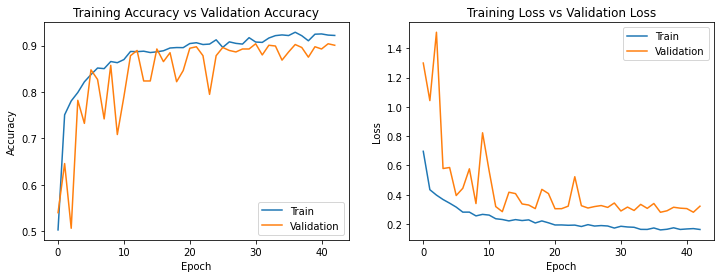

In [17]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='lower right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()